In [1]:
IS_CUSTOM_DATA = False  # If True, the dataset has to be uploaded manually

USER_ID_COL = "User-ID"  # Must not be '_user_id' for this notebook to run successfully
ITEM_ID_COL = "ISBN"  # Must not be '_item_id' for this notebook to run successfully
ITEM_INFO_COL = (
    "Book-Title"  # Must not be '_item_info' for this notebook to run successfully
)
RATING_COL = (
    "Book-Rating"  # Must not be '_rating' for this notebook to run successfully
)
IS_SAMPLE = True  # If True, use only <SAMPLE_ROWS> rows of data for training; otherwise, use all data
SAMPLE_ROWS = 5000  # If IS_SAMPLE is True, use only this number of rows for training

DATA_FOLDER = "Files/book-recommendation/"  # Folder that contains the datasets
ITEMS_FILE = "Books.csv"  # File that contains the item information
USERS_FILE = "Users.csv"  # File that contains the user information
RATINGS_FILE = "Ratings.csv"  # File that contains the rating information

EXPERIMENT_NAME = "aisample-recommendation"  # MLflow experiment name

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 3, Finished, Available, Finished)

In [2]:
if not IS_CUSTOM_DATA:
    # Download data files into a lakehouse if they don't exist
    import os, requests

    remote_url = "https://synapseaisolutionsa.z13.web.core.windows.net/data/Book-Recommendation-Dataset"
    file_list = ["Books.csv", "Ratings.csv", "Users.csv"]
    download_path = f"/lakehouse/default/{DATA_FOLDER}/raw"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError(
            "Default lakehouse not found, please add a lakehouse and restart the session."
        )
    os.makedirs(download_path, exist_ok=True)
    for fname in file_list:
        if not os.path.exists(f"{download_path}/{fname}"):
            r = requests.get(f"{remote_url}/{fname}", timeout=30)
            with open(f"{download_path}/{fname}", "wb") as f:
                f.write(r.content)
    print("Downloaded demo data files into lakehouse.")

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 4, Finished, Available, Finished)

Downloaded demo data files into lakehouse.


In [3]:
# Set up MLflow for experiment tracking
import mlflow

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Disable MLflow autologging

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 5, Finished, Available, Finished)

In [4]:
df_items = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_FOLDER}/raw/{ITEMS_FILE}")
    .cache()
)

df_ratings = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_FOLDER}/raw/{RATINGS_FILE}")
    .cache()
)

df_users = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_FOLDER}/raw/{USERS_FILE}")
    .cache()
)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 6, Finished, Available, Finished)

# **Step 2: Perform exploratory data analysis**
## **Display raw data**
Explore the DataFrames with the display command. With this command, you can view high-level DataFrame statistics, and understand how different dataset columns relate to each other. Before you explore the datasets, use this code to import the required libraries:

In [5]:
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()  # Adjusting plotting style
import pandas as pd  # DataFrames

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 7, Finished, Available, Finished)

In [6]:
display(df_items, summary=True)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 61eed207-aff7-48c3-8098-ac8b490c05c5)

In [7]:
df_items = (
    StringIndexer(inputCol=ITEM_ID_COL, outputCol="_item_id")
    .setHandleInvalid("skip")
    .fit(df_items)
    .transform(df_items)
    .withColumn("_item_id", F.col("_item_id").cast("int"))
)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 9, Finished, Available, Finished)

In [8]:
display(df_items.sort(F.col("_item_id").desc()))

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 10, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 1781414a-6e7c-41d6-8132-15607b23f4d6)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 11, Finished, Available, Finished)

Text(0.5, 1.0, 'Top 10 authors with maximum number of books')

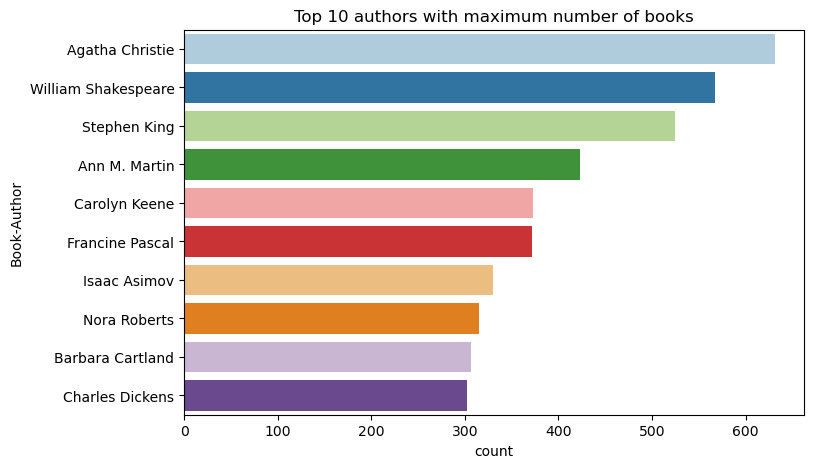

In [9]:
df_books = df_items.toPandas() # Create a pandas DataFrame from the Spark DataFrame for visualization
plt.figure(figsize=(8,5))
sns.countplot(y="Book-Author",palette = 'Paired', data=df_books,order=df_books['Book-Author'].value_counts().index[0:10])
plt.title("Top 10 authors with maximum number of books")

In [10]:
display(df_users, summary=True)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 12, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 69a317b6-01c8-4e17-a228-dcb49d2c0c97)

In [12]:
df_users = df_users.dropna(subset=(USER_ID_COL))
display(df_users, summary=True)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 14, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 7932b501-7899-41e3-8be0-827fbc12cf6f)

In [13]:
df_users = (
    StringIndexer(inputCol=USER_ID_COL, outputCol="_user_id")
    .setHandleInvalid("skip")
    .fit(df_users)
    .transform(df_users)
    .withColumn("_user_id", F.col("_user_id").cast("int"))
)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 15, Finished, Available, Finished)

In [14]:
display(df_users.sort(F.col("_user_id").desc()))

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 16, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 27144e75-f67a-464a-ae06-237ad544fd11)

In [15]:
display(df_ratings, summary=True)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 17, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, acaf154e-d2ed-4878-b1c3-07443c71b21a)

In [16]:
ratings = [i[0] for i in df_ratings.select(RATING_COL).distinct().collect()]
print(ratings)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 18, Finished, Available, Finished)

[1, 6, 3, 5, 9, 4, 8, 7, 10, 2, 0]


StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 19, Finished, Available, Finished)

Text(0.5, 1.0, 'Top 10 books per number of ratings')

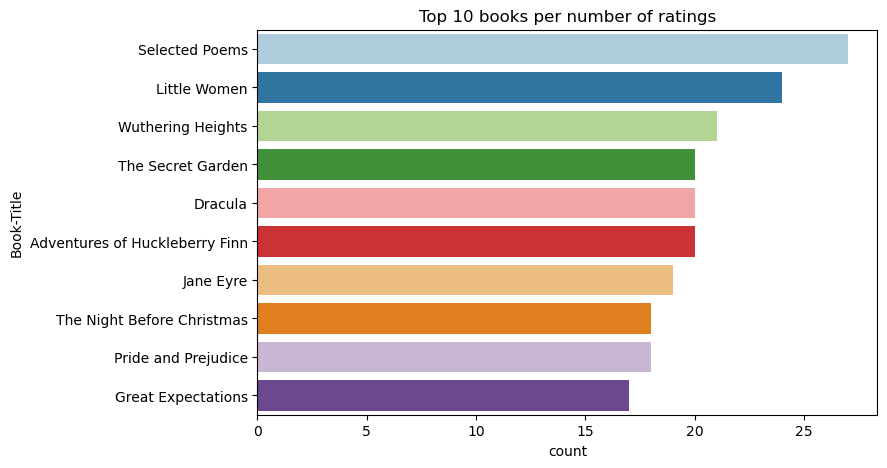

In [17]:
plt.figure(figsize=(8,5))
sns.countplot(y="Book-Title",palette = 'Paired',data= df_books, order=df_books['Book-Title'].value_counts().index[0:10])
plt.title("Top 10 books per number of ratings")

# **Merge data**
Merge the three DataFrames into one DataFrame for a more comprehensive analysis:

In [18]:
df_all = df_ratings.join(df_users, USER_ID_COL, "inner").join(
    df_items, ITEM_ID_COL, "inner"
)
df_all_columns = [
    c for c in df_all.columns if c not in ["_user_id", "_item_id", RATING_COL]
]

# Reorder the columns to ensure that _user_id, _item_id, and Book-Rating are the first three columns
df_all = (
    df_all.select(["_user_id", "_item_id", RATING_COL] + df_all_columns)
    .withColumn("id", F.monotonically_increasing_id())
    .cache()
)

display(df_all)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 20, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 9d198844-bafe-44c7-b6f8-c4398860b0c8)

In [19]:
print(f"Total Users: {df_users.select('_user_id').distinct().count()}")
print(f"Total Items: {df_items.select('_item_id').distinct().count()}")
print(f"Total User-Item Interactions: {df_all.count()}")

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 21, Finished, Available, Finished)

Total Users: 278858
Total Items: 271360
Total User-Item Interactions: 1031136


# **Compute and plot the most popular items**
Use this code to compute and display the top 10 most popular books:

In [20]:
# Compute top popular products
df_top_items = (
    df_all.groupby(["_item_id"])
    .count()
    .join(df_items, "_item_id", "inner")
    .sort(["count"], ascending=[0])
)

# Find top <topn> popular items
topn = 10
pd_top_items = df_top_items.limit(topn).toPandas()
pd_top_items.head(10)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 22, Finished, Available, Finished)

,_item_id,count,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,216737,2502,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
1,38729,1295,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
2,71056,883,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
3,7378,732,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
4,32497,723,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...
5,87704,647,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.0...,http://images.amazon.com/images/P/044023722X.0...,http://images.amazon.com/images/P/044023722X.0...
6,21423,615,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...
7,145506,614,067976402X,Snow Falling on Cedars,David Guterson,1995,Vintage Books USA,http://images.amazon.com/images/P/067976402X.0...,http://images.amazon.com/images/P/067976402X.0...,http://images.amazon.com/images/P/067976402X.0...
8,133573,586,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...
9,94175,585,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...


StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 23, Finished, Available, Finished)

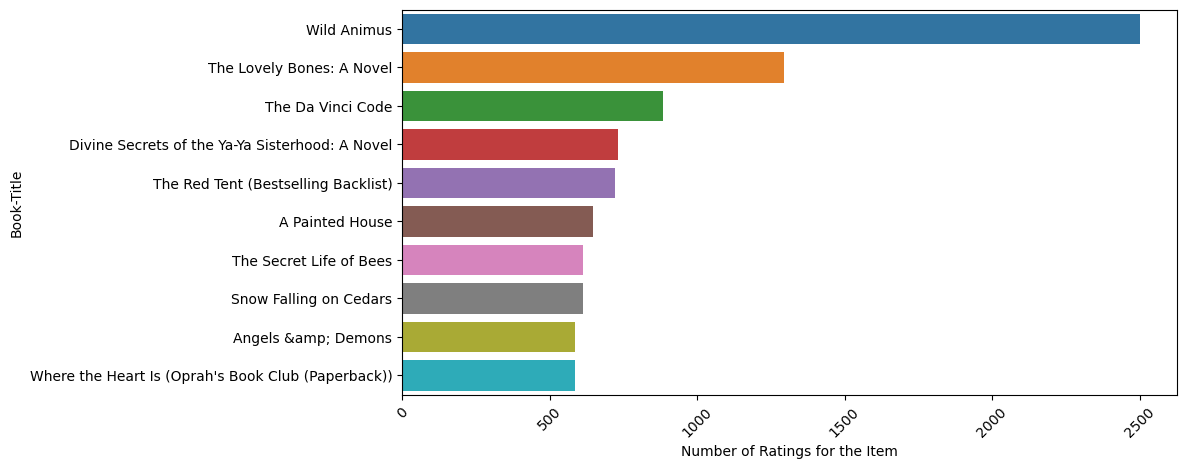

In [21]:
# Plot top <topn> items
f, ax = plt.subplots(figsize=(10, 5))
plt.xticks(rotation="vertical")
sns.barplot(y=ITEM_INFO_COL, x="count", data=pd_top_items)
ax.tick_params(axis='x', rotation=45)
plt.xlabel("Number of Ratings for the Item")
plt.show()

# **Prepare training and test datasets**
The ALS matrix requires some data preparation before training. Use this code sample to prepare the data. The code performs these actions:

Cast the rating column to the correct type
Sample the training data with user ratings
Split the data into training and test datasets

In [ ]:
if IS_SAMPLE:
    # Must sort by '_user_id' before performing limit to ensure that ALS works normally
    # If training and test datasets have no common _user_id, ALS will fail
    df_all = df_all.sort("_user_id").limit(SAMPLE_ROWS)

# Cast the column into the correct type
df_all = df_all.withColumn(RATING_COL, F.col(RATING_COL).cast("float"))

# Using a fraction between 0 and 1 returns the approximate size of the dataset; for example, 0.8 means 80% of the dataset
# Rating = 0 means the user didn't rate the item, so it can't be used for training
# We use the 80% of the dataset with rating > 0 as the training dataset
fractions_train = {0: 0}
fractions_test = {0: 0}
for i in ratings:
    if i == 0:
        continue
    fractions_train[i] = 0.8
    fractions_test[i] = 1
# Training dataset
train = df_all.sampleBy(RATING_COL, fractions=fractions_train)

# Join with leftanti will select all rows from df_all with rating > 0 and not in the training dataset; for example, the remaining 20% of the dataset
# test dataset
test = df_all.join(train, on="id", how="leftanti").sampleBy(
    RATING_COL, fractions=fractions_test
)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, -1, Cancelled, , Cancelled)

In [23]:
# Compute the sparsity of the dataset
def get_mat_sparsity(ratings):
    # Count the total number of ratings in the dataset - used as numerator
    count_nonzero = ratings.select(RATING_COL).count()
    print(f"Number of rows: {count_nonzero}")

    # Count the total number of distinct user_id and distinct product_id - used as denominator
    total_elements = (
        ratings.select("_user_id").distinct().count()
        * ratings.select("_item_id").distinct().count()
    )

    # Calculate the sparsity by dividing the numerator by the denominator
    sparsity = (1.0 - (count_nonzero * 1.0) / total_elements) * 100
    print("The ratings DataFrame is ", "%.4f" % sparsity + "% sparse.")

get_mat_sparsity(df_all)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 25, Finished, Available, Finished)

Number of rows: 5000
The ratings DataFrame is  99.7462% sparse.


In [24]:
# Check the ID range
# ALS supports only values in the integer range
print(f"max user_id: {df_all.agg({'_user_id': 'max'}).collect()[0][0]}")
print(f"max user_id: {df_all.agg({'_item_id': 'max'}).collect()[0][0]}")

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 26, Finished, Available, Finished)

max user_id: 1347
max user_id: 271357


# **Step 3: Develop and train the model**
Train an ALS model to give users personalized recommendations.

## **Define the model**
Spark ML provides a convenient API for building the ALS model. However, the model doesn't reliably handle problems like data sparsity and cold start (making recommendations when the users or items are new). To improve model performance, combine cross-validation and automatic hyperparameter tuning.

Use this code to import the libraries required for model training and evaluation:

In [25]:
# Import Spark required libraries
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

# Specify the training parameters
num_epochs = 1  # Number of epochs; here we use 1 to reduce the training time
rank_size_list = [64]  # The values of rank in ALS for tuning
reg_param_list = [0.01, 0.1]  # The values of regParam in ALS for tuning
model_tuning_method = "TrainValidationSplit"  # TrainValidationSplit or CrossValidator
# Build the recommendation model by using ALS on the training data
# We set the cold start strategy to 'drop' to ensure that we don't get NaN evaluation metrics
als = ALS(
    maxIter=num_epochs,
    userCol="_user_id",
    itemCol="_item_id",
    ratingCol=RATING_COL,
    coldStartStrategy="drop",
    implicitPrefs=False,
    nonnegative=True,
)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 27, Finished, Available, Finished)

# **Tune model hyperparameters**
The next code sample constructs a parameter grid, to help search over the hyperparameters. The code also creates a regression evaluator that uses the root-mean-square error (RMSE) as the evaluation metric:

In [26]:
#  Construct a grid search to select the best values for the training parameters
param_grid = (
    ParamGridBuilder()
    .addGrid(als.rank, rank_size_list)
    .addGrid(als.regParam, reg_param_list)
    .build()
)

print("Number of models to be tested: ", len(param_grid))

# Define the evaluator and set the loss function to the RMSE 
evaluator = RegressionEvaluator(
    metricName="rmse", labelCol=RATING_COL, predictionCol="prediction"
)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 28, Finished, Available, Finished)

Number of models to be tested:  2


In [27]:
# Build cross-validation by using CrossValidator and TrainValidationSplit
if model_tuning_method == "CrossValidator":
    tuner = CrossValidator(
        estimator=als,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=5,
        collectSubModels=True,
    )
elif model_tuning_method == "TrainValidationSplit":
    tuner = TrainValidationSplit(
        estimator=als,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        # 80% of the training data will be used for training; 20% for validation
        trainRatio=0.8,
        collectSubModels=True,
    )
else:
    raise ValueError(f"Unknown model_tuning_method: {model_tuning_method}")

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 29, Finished, Available, Finished)

# **Evaluate the model**
You should evaluate modules against the test data. A well-trained model should have high metrics on the dataset.

An overfitted model might need an increase in the size of the training data, or a reduction of some of the redundant features. The model architecture might need to change, or its parameters might need some fine tuning.

In [28]:
def evaluate(model, data, verbose=0):
    """
    Evaluate the model by computing rmse, mae, r2, and variance over the data.
    """

    predictions = model.transform(data).withColumn(
        "prediction", F.col("prediction").cast("double")
    )

    if verbose > 1:
        # Show 10 predictions
        predictions.select("_user_id", "_item_id", RATING_COL, "prediction").limit(
            10
        ).show()

    # Initialize the regression evaluator
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=RATING_COL)

    _evaluator = lambda metric: evaluator.setMetricName(metric).evaluate(predictions)
    rmse = _evaluator("rmse")
    mae = _evaluator("mae")
    r2 = _evaluator("r2")
    var = _evaluator("var")

    if verbose > 0:
        print(f"RMSE score = {rmse}")
        print(f"MAE score = {mae}")
        print(f"R2 score = {r2}")
        print(f"Explained variance = {var}")

    return predictions, (rmse, mae, r2, var)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 30, Finished, Available, Finished)

# **Track the experiment by using MLflow**
Use MLflow to track all the experiments and to log parameters, metrics, and models. To start model training and evaluation, use this code:

In [29]:
from mlflow.models.signature import infer_signature

with mlflow.start_run(run_name="als"):
    # Train models
    models = tuner.fit(train)
    best_metrics = {"RMSE": 10e6, "MAE": 10e6, "R2": 0, "Explained variance": 0}
    best_index = 0
    # Evaluate models
    # Log models, metrics, and parameters
    for idx, model in enumerate(models.subModels):
        with mlflow.start_run(nested=True, run_name=f"als_{idx}") as run:
            print("\nEvaluating on test data:")
            print(f"subModel No. {idx + 1}")
            predictions, (rmse, mae, r2, var) = evaluate(model, test, verbose=1)

            signature = infer_signature(
                train.select(["_user_id", "_item_id"]),
                predictions.select(["_user_id", "_item_id", "prediction"]),
            )
            print("log model:")
            mlflow.spark.log_model(
                model,
                f"{EXPERIMENT_NAME}-alsmodel",
                signature=signature,
                registered_model_name=f"{EXPERIMENT_NAME}-alsmodel",
                dfs_tmpdir="Files/spark",
            )
            print("log metrics:")
            current_metric = {
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "Explained variance": var,
            }
            mlflow.log_metrics(current_metric)
            if rmse < best_metrics["RMSE"]:
                best_metrics = current_metric
                best_index = idx

            print("log parameters:")
            mlflow.log_params(
                {
                    "subModel_idx": idx,
                    "num_epochs": num_epochs,
                    "rank_size_list": rank_size_list,
                    "reg_param_list": reg_param_list,
                    "model_tuning_method": model_tuning_method,
                    "DATA_FOLDER": DATA_FOLDER,
                }
            )
    # Log the best model and related metrics and parameters to the parent run
    mlflow.spark.log_model(
        models.subModels[best_index],
        f"{EXPERIMENT_NAME}-alsmodel",
        signature=signature,
        registered_model_name=f"{EXPERIMENT_NAME}-alsmodel",
        dfs_tmpdir="Files/spark",
    )
    mlflow.log_metrics(best_metrics)
    mlflow.log_params(
        {
            "subModel_idx": idx,
            "num_epochs": num_epochs,
            "rank_size_list": rank_size_list,
            "reg_param_list": reg_param_list,
            "model_tuning_method": model_tuning_method,
            "DATA_FOLDER": DATA_FOLDER,
        }
    )

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 31, Finished, Available, Finished)


Evaluating on test data:
subModel No. 1
log metrics:
log parameters:


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/09/27 17:13:06 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp9yz5136m/model, flavor: spark). Fall back to return ['pyspark==3.5.1.


Evaluating on test data:
subModel No. 2
RMSE score = 0.8837609999299703
MAE score = 0.16755248482519458
R2 score = 0.4063293995867473
Explained variance = 3.644705553166622
log model:
log metrics:
log parameters:


2025/09/27 17:15:09 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp7xhaon7k/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
2025-09-27:17:15:16,111 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"57b1f69b-c9bb-472a-af2d-b8b2d7ddb78c","errorCode":"ItemDisplayNameAlreadyInUse","message":"Requested \'aisample-recommendation-alsmodel\' is already in use"}'
Registered model 'aisample-recommendation-alsmodel' already exists. Creating a new version of this model...


2025/09/27 17:15:42 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpct4td1ke/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
2025-09-27:17:15:48,556 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"57d943fe-2aee-4b45-b0ce-8ac171448946","errorCode":"ItemDisplayNameAlreadyInUse","message":"Requested \'aisample-recommendation-alsmodel\' is already in use"}'
Registered model 'aisample-recommendation-alsmodel' already exists. Creating a new version of this model...
2025/09/27 17:15:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aisample-recommendation-alsmodel, version 3
Created version '3' of model 'aisample-recommendation-alsmodel'.


# **Step 4: Load the final model for scoring and make predictions**
After you finish the model training, and then select the best model, load the model for scoring (sometimes called inferencing). This code loads the model and uses predictions to recommend the top 10 books for each user:

In [30]:
# Load the best model
# MLflow uses PipelineModel to wrap the original model, so we extract the original ALSModel from the stages
model_uri = f"models:/{EXPERIMENT_NAME}-alsmodel/1"
loaded_model = mlflow.spark.load_model(model_uri, dfs_tmpdir="Files/spark").stages[-1]

# Generate top 10 book recommendations for each user
userRecs = loaded_model.recommendForAllUsers(10)

# Represent the recommendations in an interpretable format
userRecs = (
    userRecs.withColumn("rec_exp", F.explode("recommendations"))
    .select("_user_id", F.col("rec_exp._item_id"), F.col("rec_exp.rating"))
    .join(df_items.select(["_item_id", "Book-Title"]), on="_item_id")
)
userRecs.limit(10).show()

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 32, Finished, Available, Finished)

2025/09/27 17:19:33 INFO mlflow.spark: 'models:/aisample-recommendation-alsmodel/1' resolved as 'abfss://8ce45ddf-ee1d-4255-b4bc-75ab18e6645f@onelakewesteurope.pbidedicated.windows.net/73007153-1797-4d17-93bc-260ff60997f1/Data/a314089d-d5ba-42b3-b0a4-a48599675527/artifacts'


2025/09/27 17:19:34 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2025/09/27 17:19:35 INFO mlflow.spark: File 'models:/aisample-recommendation-alsmodel/1/sparkml' not found on DFS. Will attempt to upload the file.
2025/09/27 17:19:38 INFO mlflow.spark: Copied SparkML model to Files/spark/ec16f179-6a53-4ab2-bf8a-0fb05c50fe46


+--------+--------+---------+--------------------+
|_item_id|_user_id|   rating|          Book-Title|
+--------+--------+---------+--------------------+
|   78362|       9|7.9994283|The Cat Who Smell...|
|   94175|       9|5.4810333|Where the Heart I...|
|  119367|       9| 5.289361|Anne Frank: The D...|
|  103040|       9|4.7848535|Les Miserables a ...|
|  153402|       9|4.6341615|There's a Bat in ...|
|  138834|       9|4.6341615|FOREVER : A Novel...|
|   87077|       9|4.6341615|         The Chamber|
|   58256|       9|4.6341615|Wonders Never Cea...|
|   58254|       9|4.6341615|You're My Baby (9...|
|   53879|       9|4.6341615|Conflict of Inter...|
+--------+--------+---------+--------------------+



StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 33, Finished, Available, Finished)

# **Save the predictions to the lakehouse**
Use this code to write the recommendations back to the lakehouse:

In [31]:
# Code to save userRecs into the lakehouse
userRecs.write.format("delta").mode("overwrite").save(
    f"{DATA_FOLDER}/predictions/userRecs"
)

StatementMeta(, c367e88a-8d24-4856-b0ee-2a348a7fe6d7, 34, Finished, Available, Finished)